In [1]:
import datetime
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
from nsepy import get_history
import matplotlib.pyplot as plt
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
%matplotlib inline

In [2]:
stock_name = input('Enter NSE Stock Name: ').upper()
date_entry = input('Enter a date in yyyy,m,d format')
year, month, day = map(int, date_entry.split(','))
start_date= datetime.date(year, month, day)
end_date = date.today()

# get_history(symbol = 'SBIN', start=date(2015,1,1), end=date(2022,3,1))
def stock_df(s, sd, ed):
    df = get_history(symbol=s, start=sd, end=ed)
    return df

In [3]:
df = stock_df(stock_name, start_date, end_date)
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,TATAMOTORS,EQ,495.55,494.50,499.45,492.25,498.55,498.45,496.76,934528,4.642335e+13,12769,303443,0.3247
2015-01-02,TATAMOTORS,EQ,498.45,497.25,517.40,497.25,513.50,511.80,510.18,4148596,2.116515e+14,60297,2098181,0.5058
2015-01-05,TATAMOTORS,EQ,511.80,510.10,526.00,506.70,524.10,523.80,518.60,6686952,3.467850e+14,89227,3696954,0.5529
2015-01-06,TATAMOTORS,EQ,523.80,514.35,514.35,499.25,502.00,501.40,504.78,7894918,3.985170e+14,160548,4736934,0.6000
2015-01-07,TATAMOTORS,EQ,501.40,495.00,500.40,489.20,493.70,493.85,494.52,9134678,4.517269e+14,166649,5515549,0.6038


In [4]:
df = df['Close']
df.head()

Date
2015-01-01    498.45
2015-01-02    511.80
2015-01-05    523.80
2015-01-06    501.40
2015-01-07    493.85
Name: Close, dtype: float64

In [5]:
px.line(df)

In [6]:
df=df.reset_index()['Close']
df.head(), df.shape

(0    498.45
 1    511.80
 2    523.80
 3    501.40
 4    493.85
 Name: Close, dtype: float64,
 (1845,))

In [7]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]
train_data.shape,test_data.shape

((1476,), (369,))

In [8]:
# Normalizing the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.values.reshape(-1,1))
test_data = scaler.transform(test_data.values.reshape(-1,1))
train_data.shape, test_data.shape

((1476, 1), (369, 1))

In [9]:
train_data

array([[0.80324525],
       [0.82800185],
       [0.85025498],
       ...,
       [0.20834492],
       [0.21066296],
       [0.21743162]])

In [10]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
X_train, y_train = create_dataset(train_data, 50)
X_test, y_test = create_dataset(test_data, 50)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1425, 50), (1425,), (318, 50), (318,))

In [13]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [14]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=50, verbose=1)

Epoch 1/100
29/29 [==============================] - 10s 133ms/step - loss: 0.0330 - val_loss: 0.0055
Epoch 2/100
29/29 [==============================] - 3s 86ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 3/100
29/29 [==============================] - 2s 78ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 4/100
29/29 [==============================] - 2s 79ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 5/100
29/29 [==============================] - 3s 93ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 6/100
29/29 [==============================] - 3s 91ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 7/100
29/29 [==============================] - 2s 79ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 8/100
29/29 [==============================] - 2s 83ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 9/100
29/29 [==============================] - 3s 91ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 10/100
29/29 [==============================] - 3s 92ms/step - loss: 0.0013 - val_loss: 0.00

In [17]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

338.7532047788055

In [20]:
math.sqrt(mean_squared_error(y_test,test_predict))

394.37582534664364

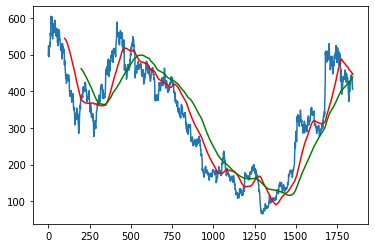

In [23]:
plt.plot(df)
plt.plot(df.rolling(100).mean(), color='red')
plt.plot(df.rolling(200).mean(), color='green')